In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


# Load R2-vs-R1 final selected data

In [3]:
import pandas as pd
import numpy as np

# Get values from df_MC4_10_act by row value
row2index = { char: i for i, char in enumerate('ABCDEFGH')}
column2index = {i: i-1 for i in range(1, 13)}

def load_data_from_xlsx_sheet(sheet, xlsx_file, col_name='activity'):
    df = pd.read_excel(xlsx_file, sheet_name=sheet, index_col=0)
    # display(df.sample(5))
    # print(df.columns)
    loc2act = {}
    for i in range(1, 13):
        for char in 'ABCDEFGH':
            loc = f'{sheet}-{char}-{i:02d}'
            try:
                act = df.iloc[row2index[char], column2index[i]]
            except:
                act = np.nan
            loc2act[loc] = act

    df = pd.DataFrame(loc2act.items(), columns=['chip_loc', col_name])
    return df
# display(load_data_from_xlsx_sheet('MC3-9', xlsx_file).sample(5))

def get_chip_loc_id_from_chip_loc(chip_loc):
    """ Input: MC4-10-A-01
        Output: MC4-10-1, where 1 = (A-A)*12 + 1
    """
    try:
        mc, sheet, row, col  = chip_loc.split('-')
        row = row[0]
        col = int(col)
        return f'{mc}-{sheet}-{(ord(row) - ord("A"))*12 + col}'
    except:
        print(f'Error in get_chip_loc_id_from_chip_loc: chip_loc {chip_loc}')
        return None

# get_chip_loc_id_from_chip_loc('MC4-10-H-12')

In [6]:
r2_vs_r1_xls_path = 'data/round2/wet-lab/R1-2_final_activity.xlsx'

df_R2_vs_R1 = load_data_from_xlsx_sheet('Final_act', r2_vs_r1_xls_path)
df_R2_vs_R1_label = load_data_from_xlsx_sheet('Final_labels', r2_vs_r1_xls_path, col_name='label')

df_R2_vs_R1_label['chip_loc'] = df_R2_vs_R1_label['chip_loc'].apply(lambda x: x.replace('Final_labels', 'Final_act'))

df_R2_vs_R1 = pd.merge(df_R2_vs_R1, df_R2_vs_R1_label, on='chip_loc')
df_R2_vs_R1.dropna(subset=['activity'], inplace=True)
df_R2_vs_R1.head()

,chip_loc,activity,label
0,Final_act-A-01,4.925263,R2-3-A4
1,Final_act-B-01,3.690084,R2-4-H5
2,Final_act-C-01,4.398588,R2-10-B11
3,Final_act-D-01,3.682034,R2-15-H8
4,Final_act-E-01,3.356246,MC5-1-B10


In [8]:
df_R2_vs_R1_grouped_mean = df_R2_vs_R1.groupby('label').agg({'activity': 'mean'},).reset_index().rename(columns={'activity': 'mean_activity'})
df_R2_vs_R1_grouped_std = df_R2_vs_R1.groupby('label').agg({'activity': 'std'},).reset_index().rename(columns={'activity': 'std_activity'})
df_R2_vs_R1_grouped = pd.merge(df_R2_vs_R1_grouped_mean, df_R2_vs_R1_grouped_std, on='label')
df_R2_vs_R1_grouped['label'] = df_R2_vs_R1_grouped['label'].apply(lambda x: x if x != '对照Alkb' else 'WT')
df_R2_vs_R1_grouped.head()

,label,mean_activity,std_activity
0,L2FP,2.169722,0.066837
1,MC3-1-H7,1.443646,0.367240
2,MC3-4-H12,2.630844,0.240688
3,MC3-7-G5,2.771272,0.342686
4,MC3-8-B10,2.769094,0.214768


In [12]:
def format_chip_loc_id(chip_loc_id):
    """
    Format R2-1-A4 to R2-1-04, R2-1-H12 to R2-1-H12
    """
    try:
        mc, sheet, loc = chip_loc_id.split('-')
        alphabet = loc[0]
        loc = int(loc[1:])
        return f'{mc}-{sheet}-{alphabet}-{loc:02d}'
    except:
        print(f"error in the chip_loc_id: {chip_loc_id}")
        return chip_loc_id

In [ ]:
df_R2_vs_R1_grouped['Source'] = df_R2_vs_R1_grouped['label'].apply(
    lambda x: 'R2' if x.startswith('R2-') or x == 'R2FP'
    else ('R1' if x.startswith('MC') or x.startswith('L2FP') 
                else ('WT' if x == 'WT' else 'Unknown'))
)
df_R2_selected = df_R2_vs_R1_grouped[df_R2_vs_R1_grouped['Source'] == 'R2'].copy()
df_R1_selected = df_R2_vs_R1_grouped[(df_R2_vs_R1_grouped['Source'] == 'R1') | (df_R2_vs_R1_grouped['Source'] == 'WT')].copy()

df_R1_selected.sort_values('mean_activity', ascending=True, inplace=True)
df_R2_selected.sort_values('mean_activity', ascending=True, inplace=True)
df_R2_vs_R1_selected = pd.concat([df_R1_selected, df_R2_selected])
df_R2_vs_R1_selected['chip_loc_id'] = df_R2_vs_R1_selected['label'].apply(lambda x: get_chip_loc_id_from_chip_loc(format_chip_loc_id(x)))

# For data merge with R1
df_R1_selected_to_merge = df_R2_vs_R1_selected[df_R2_vs_R1_selected.Source == 'R1'].copy().set_index('chip_loc_id')
df_R1_selected_to_merge['mean_act'] = df_R1_selected_to_merge['mean_activity']

df_R2_selected_to_merge = df_R2_vs_R1_selected[df_R2_vs_R1_selected.Source == 'R2'].copy().set_index('chip_loc_id')
df_R2_selected_to_merge['mean_act'] = df_R2_selected_to_merge['mean_activity']
df_R1_selected_to_merge.head()

error in the chip_loc_id: WT
Error in get_chip_loc_id_from_chip_loc: chip_loc WT
error in the chip_loc_id: L2FP
Error in get_chip_loc_id_from_chip_loc: chip_loc L2FP
error in the chip_loc_id: R2FP
Error in get_chip_loc_id_from_chip_loc: chip_loc R2FP


,label,mean_activity,std_activity,Source,mean_act
chip_loc_id,,,,,
MC3-1-91,MC3-1-H7,1.443646,0.367240,R1,1.443646
None,L2FP,2.169722,0.066837,R1,2.169722
MC3-4-96,MC3-4-H12,2.630844,0.240688,R1,2.630844
MC5-8-60,MC5-8-E12,2.684107,0.120462,R1,2.684107
MC5-3-33,MC5-3-C9,2.701799,0.396283,R1,2.701799
MC3-8-22,MC3-8-B10,2.769094,0.214768,R1,2.769094
MC3-7-77,MC3-7-G5,2.771272,0.342686,R1,2.771272
MC5-6-90,MC5-6-H6,3.021990,0.036136,R1,3.021990
MC4-1-43,MC4-1-D7,3.029921,0.163974,R1,3.029921


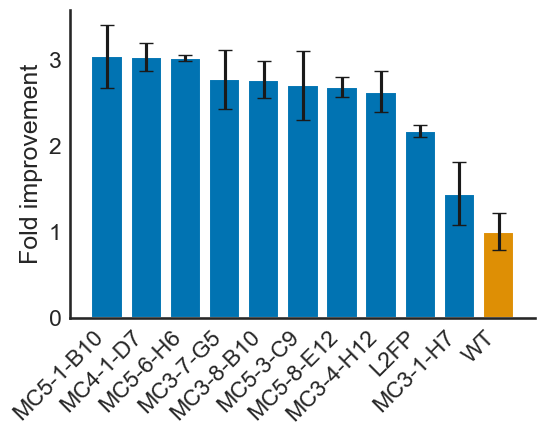

In [18]:
# Plot R1 top 10 figure
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(6, 4))
plot_style_utils.prettify_ax(ax)

df_R1 = df_R2_vs_R1_selected[(df_R2_vs_R1_selected['Source'] == 'R1') | (df_R2_vs_R1_selected['Source'] == 'WT')].copy()
df_R1 = df_R1.sort_values('mean_activity', ascending=False)#.head(10)

ax.bar(df_R1['label'], df_R1['mean_activity'], yerr=df_R1['std_activity'], capsize=5, color=[plot_style_utils.CAT_PALETTE[0]]* 10 + [plot_style_utils.CAT_PALETTE[1]])

ax.set_ylabel('Fold improvement')
ax.set_xlabel('')
ax.set_xticks(range(len(df_R1)))
ax.set_xticklabels(df_R1['label'], rotation=45, ha='right')
plot_style_utils.save_for_pub(fig, path='figures/round1/wetlab_R1_top10_activity')


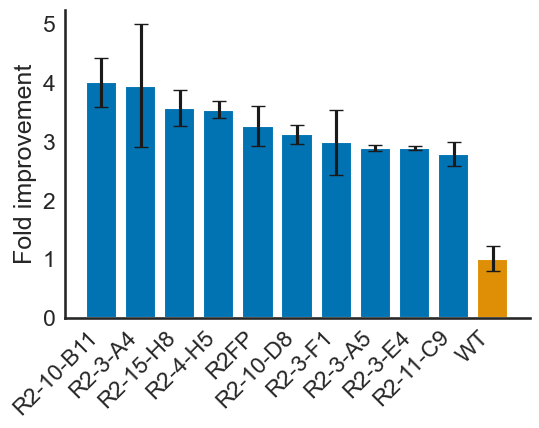

In [19]:
# Plot R2 top 10 figure
import pandas as pd
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(6, 4))
plot_style_utils.prettify_ax(ax)

df_R2 = df_R2_vs_R1_selected[(df_R2_vs_R1_selected['Source'] == 'R2') | (df_R2_vs_R1_selected['Source'] == 'WT')].copy()
df_R2 = df_R2.sort_values('mean_activity', ascending=False)
df_R2_top10 = df_R2.head(10)
df_WT = df_R2_vs_R1_selected[df_R2_vs_R1_selected['Source'] == 'WT']
df_R2 = pd.concat([df_R2_top10, df_WT], axis=0)
ax.bar(df_R2['label'], df_R2['mean_activity'], yerr=df_R2['std_activity'], capsize=5, color=[plot_style_utils.CAT_PALETTE[0]]* 10 + [plot_style_utils.CAT_PALETTE[1]])

ax.set_ylabel('Fold improvement')
ax.set_xlabel('')
ax.set_xticks(range(len(df_R2)))
ax.set_xticklabels(df_R2['label'], rotation=45, ha='right')
plot_style_utils.save_for_pub(fig, path='figures/round2/wetlab_R2_top10_activity')

# Compare all the R1 and R2 data

In [26]:
df_R1_merged = pd.read_csv('data/round1/wet-lab/mcs_uniq_join_duplicated-yh-top_merged2.csv')
print(len(df_R1_merged))
df_R1_merged.head(2)

2415


,id,library,chip_loc_id,chip_loc,sequence,savinase_mutations,n_muts,activity,is_in_mc,mut_not_in,is_dup,mean_activity,n_dup,act_max,act_min,act_min_max_diff,dup_locs,dup_activities,mean_act,checked_act
0,MC3-8-22-MP-F2_B10,Library 3,MC3-8-22,MC3-8-B-10,AQTVPWGISRVQAPAAHNRGLTGPGVKVAVLDTGISTHPDLKIRGG...,S3T/S24P/N43K/A98S/Y209L/T213R/N218S/T224A/S256K,9,5.607833,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.207822,4.207822
1,rf 1 MC4-1-43-MP-F2_D05,Library 4,MC4-1-43,MC4-1-D-07,AQVVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,S3V/N76D/N204S/Y209L/T213E/N218S/T224A/S256N,8,3.041900,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.239346,3.239346


In [27]:
df_R1_merged = df_R1_merged.drop_duplicates(subset='chip_loc_id', keep='first').set_index('chip_loc_id')

df_R1_merged.update(df_R1_selected_to_merge)

df_R1_merged.to_csv('data/round1/wet-lab/mcs_uniq_join_duplicated-yh-top_merged2_updated.csv')

print(len(df_R1_merged))
df_R1_merged.head(2)

2396


,id,library,chip_loc,sequence,savinase_mutations,n_muts,activity,is_in_mc,mut_not_in,is_dup,mean_activity,n_dup,act_max,act_min,act_min_max_diff,dup_locs,dup_activities,mean_act,checked_act
chip_loc_id,,,,,,,,,,,,,,,,,,,
MC3-8-22,MC3-8-22-MP-F2_B10,Library 3,MC3-8-B-10,AQTVPWGISRVQAPAAHNRGLTGPGVKVAVLDTGISTHPDLKIRGG...,S3T/S24P/N43K/A98S/Y209L/T213R/N218S/T224A/S256K,9,5.607833,1,NaN,0,2.769094,NaN,NaN,NaN,NaN,NaN,NaN,2.769094,4.207822
MC4-1-43,rf 1 MC4-1-43-MP-F2_D05,Library 4,MC4-1-D-07,AQVVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,S3V/N76D/N204S/Y209L/T213E/N218S/T224A/S256N,8,3.041900,1,NaN,0,3.029921,NaN,NaN,NaN,NaN,NaN,NaN,3.029921,3.239346


In [28]:
df_R1_L1 = df_R1_merged[df_R1_merged['library'] == 'Library 1'].copy()
df_R1_L2 = df_R1_merged[df_R1_merged['library'] == 'Library 2'].copy()
df_R1_L3 = df_R1_merged[df_R1_merged['library'] == 'Library 3'].copy()
df_R1_L4 = df_R1_merged[df_R1_merged['library'] == 'Library 4'].copy()
df_R1_L5 = df_R1_merged[df_R1_merged['library'] == 'Library 5'].copy()

df_R1_L1['Source'] = 'R1-L1'
df_R1_L2['Source'] = 'R1-L2'
df_R1_L3['Source'] = 'R1-L3'
df_R1_L4['Source'] = 'R1-L4'
df_R1_L5['Source'] = 'R1-L5'

df_R1_L1.sort_values('mean_act', ascending=True, inplace=True)
df_R1_L2.sort_values('mean_act', ascending=True, inplace=True)
df_R1_L3.sort_values('mean_act', ascending=True, inplace=True)
df_R1_L4.sort_values('mean_act', ascending=True, inplace=True)
df_R1_L5.sort_values('mean_act', ascending=True, inplace=True)

print(len(df_R1_L1), len(df_R1_L2), len(df_R1_L3), len(df_R1_L4), len(df_R1_L5))

518 525 522 475 356


In [29]:
df_R2_updated = pd.read_csv('data/round2/wet-lab/R2_activity.xlsx_updated.csv')
df_R2_updated['Source'] = 'R2'
df_R2_updated['mean_act'] = df_R2_updated['activity']

df_R2_updated = df_R2_updated.drop_duplicates(subset='chip_loc_id', keep='first').set_index('chip_loc_id')
df_R2_updated.update(df_R2_selected_to_merge)

df_R2_updated.sort_values('mean_act', ascending=True, inplace=True)
df_R2_updated.head()

,chip_loc,index,activity,Source,mean_act
chip_loc_id,,,,,
R2-6-47,R2-6-D-11,551,0.021132,R2,0.021132
R2-4-42,R2-4-D-06,331,0.024420,R2,0.024420
R2-6-3,R2-6-A-03,484,0.030050,R2,0.030050
R2-6-5,R2-6-A-05,500,0.033002,R2,0.033002
R2-7-33,R2-7-C-09,630,0.033062,R2,0.033062


# Ratio of improvements in R2 vs R1 
- with 1x, 2x, 3x improvements

In [30]:
df_data_to_plot = pd.concat([df_R1_L1, df_R1_L2, df_R1_L3, df_R1_L4, df_R1_L5, df_R2_updated])
df_data_to_plot = df_data_to_plot.reset_index()
df_data_to_plot.head(2)

,chip_loc_id,id,library,chip_loc,sequence,savinase_mutations,n_muts,activity,is_in_mc,mut_not_in,...,n_dup,act_max,act_min,act_min_max_diff,dup_locs,dup_activities,mean_act,checked_act,Source,index
0,MC1-12-87,MC1-12-87-MP-F2_H03,Library 1,MC1-12-H-03,AQVVPWGISRVQPPAAHNRGLTGSGVKVAVLDTGISTHPDLRIRGG...,S3V/A13P/N43R/N76D/V84L/A98G/G127R/P131S/S166N...,19.0,0.0,0.0,A13P/V84L/G127R/S166N/Q191H/S216I/G219N/G229C/...,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,R1-L1,NaN
1,MC1-12-88,MC1-12-88-MP-F2_H04,Library 1,MC1-12-H-04,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLGTGISTHPDLNIRGG...,D32G/A98S/P131S/F189S/Y209L/T213Y/N218S/A223S/...,10.0,0.0,0.0,D32G/F189S,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,R1-L1,NaN


In [31]:
R2_n_variants_lt_1 = len(df_data_to_plot[(df_data_to_plot['mean_act'] < 1) & (df_data_to_plot['Source'].str.contains('R2'))])
R2_n_variants_gt_1 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 1) & (df_data_to_plot['Source'].str.contains('R2')) & (df_data_to_plot['mean_act'] < 2)])
R2_n_variants_gt_2 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 2) & (df_data_to_plot['Source'].str.contains('R2')) & (df_data_to_plot['mean_act'] < 3)])
R2_n_variants_gt_3 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 3) & (df_data_to_plot['Source'].str.contains('R2'))])

R2_n_variants_lt_1, R2_n_variants_gt_1, R2_n_variants_gt_2, R2_n_variants_gt_3

(227, 523, 607, 41)

In [32]:
R1_n_variants_lt_1 = len(df_data_to_plot[(df_data_to_plot['Source'].str.contains('R1')) & (df_data_to_plot['mean_act'] < 1)])
R1_n_variants_gt_1 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 1) & (df_data_to_plot['Source'].str.contains('R1')) & (df_data_to_plot['mean_act'] < 2)])
R1_n_variants_gt_2 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 2) & (df_data_to_plot['Source'].str.contains('R1')) & (df_data_to_plot['mean_act'] < 3)])
R1_n_variants_gt_3 = len(df_data_to_plot[(df_data_to_plot['mean_act'] >= 3) & (df_data_to_plot['Source'].str.contains('R1'))])

R1_n_variants_lt_1, R1_n_variants_gt_1, R1_n_variants_gt_2, R1_n_variants_gt_3

(591, 1385, 416, 3)

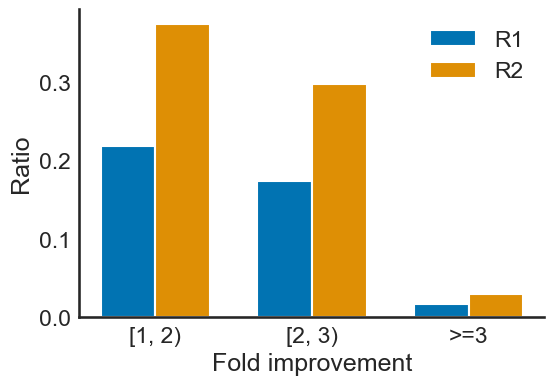

In [33]:
from utils import plot_style_utils
import seaborn as sns

plot_style_utils.set_pub_plot_context(context="talk")

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)
bins = np.linspace(0, 5, 6)

fold_improvements = ['[1, 2)', '[2, 3)', '>=3', ]
R1_counts = [R2_n_variants_gt_1, R1_n_variants_gt_2, R2_n_variants_gt_3]
R2_counts = [R2_n_variants_gt_1, R2_n_variants_gt_2, R2_n_variants_gt_3]

R1_ratio = [R1_counts[i]/len(df_data_to_plot[df_data_to_plot['Source'].str.contains('R1')])for i in range(len(fold_improvements))]
R2_ratio = [R1_counts[i]/len(df_data_to_plot[df_data_to_plot['Source'].str.contains('R2')])for i in range(len(fold_improvements))]

index = np.arange(len(fold_improvements))
bar_width = 0.35

ax.bar(index, R1_ratio, color=plot_style_utils.CAT_PALETTE[0], label='R1', width=bar_width)
ax.bar(index + bar_width, R2_ratio, color=plot_style_utils.CAT_PALETTE[1], label='R2', width=bar_width)

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(fold_improvements)

ax.set_xlabel('Fold improvement')
ax.set_ylabel('Ratio')
ax.legend(loc='upper right', frameon=False)
plot_style_utils.save_for_pub(fig, path='figures/round2/wetlab_R2_vs_R1_improvement_ratio')